In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

Text(0.5, 1.0, 'np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )')

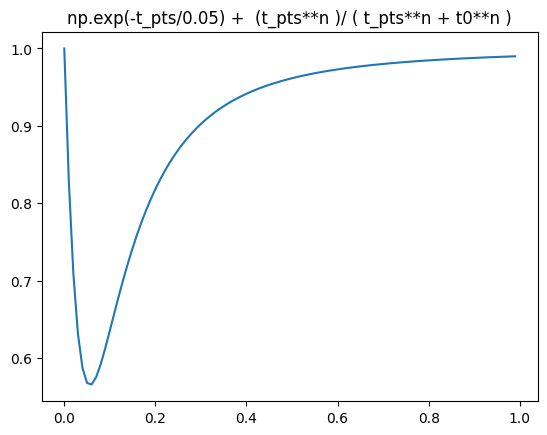

In [31]:
t_pts = np.arange(0, 1, 0.01)
n = 2
t0 = 0.2 / n

y = np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )

plt.plot(t_pts, y)
plt.title('np.exp(-t_pts/0.05) +  (t_pts**n )/ ( t_pts**n + t0**n )')

Text(0.5, 1.0, 'np.exp(-t_pts/0.05) + np.cos(8*t_pts)')

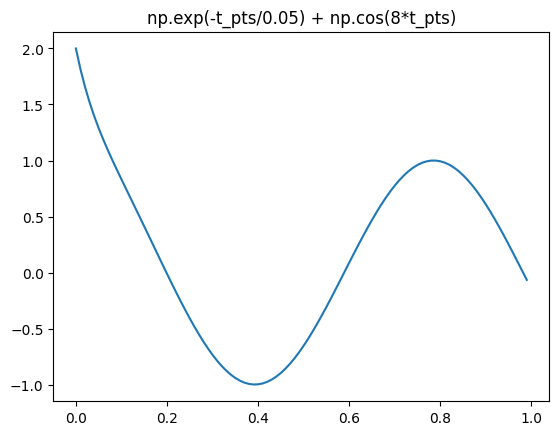

In [30]:
plt.plot(t_pts, np.exp(-t_pts/0.05) + np.cos(8*t_pts), label='cos(t)')
plt.title('np.exp(-t_pts/0.05) + np.cos(8*t_pts)')

In [8]:
def psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    t_stim = random.choice(t_stim_arr)
    
    
    choice, rt, is_act = simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD}

def decay_amount_tied_fn(t, decay_params):
    gamma = decay_params['gamma']
    sig_slope = decay_params['sig_slope']
    sig_offset = 0.2 / sig_slope

    return np.exp(-t/gamma) + ( (t**n) / (t**n + sig_offset**n) )

    

def simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, decay_params, dt):
    AI = 0; DV = Z_E; t = t_A_aff; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))
    

    is_act = 0
    while True:
        if t > t_stim + t_E_aff:
            decay = decay_amount_tied_fn(t - t_stim - t_E_aff, decay_params)
            mu = common * (rate_lambda * ILD / chi) * decay
            sigma = np.sqrt(common * decay)

            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        AI += V_A*dt + np.random.normal(0, dB)
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            while t <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    decay = decay_amount_tied_fn(t - t_stim - t_E_aff, decay_params)
                    mu = common * (rate_lambda * ILD / chi) * decay
                    sigma = np.sqrt(common * decay)

                    DV += mu*dt + sigma*np.random.normal(0, dB)

                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        # if DV != 0:
        if DV >= (1 + (L/2) - 1)*theta:
            choice = 1
        elif DV <= (1 - (L/2) - 1)*theta:
            choice = -1
        else:
            prob_hit_up = (1/L)*((DV/theta) + 1) + (0.5 - (1/L))            
            if np.random.rand() <= prob_hit_up:
                choice = 1
            else:
                choice = -1
             
    
    return choice, RT, is_act